# **Lloyds Banking Group Internship Data Science**

## **📊 Phase 2: Building a machine learning model**

### Project brief

- Welcome to the Data Science & Analytics team at Lloyds Banking Group. As a new data science graduate, you have been entrusted with a critical project that could significantly impact our customer retention strategies. Li, our senior data scientist, has specifically chosen you to take over this project due to your strong analytical skills and enthusiasm for solving real-world business problems. This is an exciting opportunity for you to apply your knowledge and make a real impact within our team.
Context

- The project you are about to embark on is the "Customer Retention Enhancement through Predictive Analytics" initiative. This project arose from an urgent need to address declining retention rates within certain segments of our customer base. Over the past few months, **we've noticed a worrying trend of increased customer churn, particularly among young professionals and small business owners.** This poses a substantial threat to our market position and long-term profitability.

- Our fictional client, SmartBank, a subsidiary of Lloyds, has reported that a substantial portion of their customer base is at risk of moving to competitors offering more personalised banking solutions. SmartBank has tasked our team with developing a predictive model to identify at-risk customers and propose targeted interventions to retain them.
Key concepts

### Key Concepts

Before you begin, it's essential to understand a few key concepts:

- Customer churn: The process by which customers stop doing business with a company. Identifying and preventing churn is crucial for maintaining a stable customer base.
    Predictive analytics: Techniques that use historical data to forecast future possibilities. In this project, you'll use predictive analytics to predict which customers are likely to churn.
    Exploratory data analysis (EDA): A method of analysing data sets to summarise their primary characteristics, often using visual strategies. EDA is crucial for understanding the data before building predictive models.
    Machine learning models: Algorithms that let computers learn from and make predictions or decisions based on data. You'll be building a classification model to predict customer churn.

### Project requirements

- **`Phase 2: Building a machine learning model`**

    - Objective: Develop a predictive model to identify customers at risk of churning and propose ways to measure the model’s performance.
    Steps:
        Choose a suitable machine learning algorithm for the classification task.
        Build and train the model to predict customer churn.
        Suggest ways to evaluate and measure the model’s performance, ensuring its reliability and accuracy.
    Deliverable: Submit a report, including the trained machine learning model and your proposed methods for evaluating and measuring the model’s performance.

In [25]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings('ignore')
from IPython.display import Image

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit


## **1 | Read Dataset**

We're working with the same dataset as in **Phase1**. 

- Having done an exploratory data analysis, we have some ideas of which data we can try to utilise in order to create a **churn binary classifier model**

- **Demographic features** such as age is definitely worth trying out, as we saw some variation in mean & median values for both subgroups

- Some form of patterns in **transactional data** was observed, so given sufficient data, the models should be able to extract some insign from the patterns which will allow the model to classify between the two classes

- Insight into user **online activity** for both groups also suggested some variability between different types of login types for churned and non-churned customers, which suggests that these features also need to be explored as possible feature candidates for improving the model metrics

- **Customer service interactions** for both groups also showed some minor differences which the model might pick up on

In [26]:
ds = pd.read_excel('Customer_Churn_Data_Large.xlsx',sheet_name=None)
ds.keys()

dict_keys(['Customer_Demographics', 'Transaction_History', 'Customer_Service', 'Online_Activity', 'Churn_Status'])

In [27]:
demographic = ds['Customer_Demographics']
transaction = ds['Transaction_History']
service = ds['Customer_Service']
activity = ds['Online_Activity']
status = ds['Churn_Status']
status['ChurnStatus'] = pd.Categorical(status['ChurnStatus'],[0,1])

In [28]:
demographic.head()

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel
0,1,62,M,Single,Low
1,2,65,M,Married,Low
2,3,18,M,Single,Low
3,4,21,M,Widowed,Low
4,5,21,M,Divorced,Medium


In [29]:
transaction.head()

,CustomerID,TransactionID,TransactionDate,AmountSpent,ProductCategory
0,1,7194,2022-03-27,416.50,Electronics
1,2,7250,2022-08-08,54.96,Clothing
2,2,9660,2022-07-25,197.50,Electronics
3,2,2998,2022-01-25,101.31,Furniture
4,2,1228,2022-07-24,397.37,Clothing


The number of rows of transactional data is much higher than the other user aggregated data

In [30]:
transaction.shape

(5054, 5)

In [31]:
service.head()

,CustomerID,InteractionID,InteractionDate,InteractionType,ResolutionStatus
0,1,6363,2022-03-31,Inquiry,Resolved
1,2,3329,2022-03-17,Inquiry,Resolved
2,3,9976,2022-08-24,Inquiry,Resolved
3,4,7354,2022-11-18,Inquiry,Resolved
4,4,5393,2022-07-03,Inquiry,Unresolved


In [32]:
activity.head()

,CustomerID,LastLoginDate,LoginFrequency,ServiceUsage
0,1,2023-10-21,34,Mobile App
1,2,2023-12-05,5,Website
2,3,2023-11-15,3,Website
3,4,2023-08-25,2,Website
4,5,2023-10-27,41,Website


In [33]:
status.head()

,CustomerID,ChurnStatus
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [34]:
status.shape

(1000, 2)

## **2 | Feature Engineering**

### Things to note

- The next step for us is to determine which features are to be used to model the customer churn

- **Churn** data for each customer **CustomerID** is found in data **status**

    - Each label is defined for a single customer, for whom we have information about whether they churned or not, which is only **1000 customers**

- From our exploratory data analysis, we found that the ratio of **churned** to **non-churned** customers is quite low, which implies that upon training our model we are facing an **imbalanced** classification problem, which is made worse by the fact that we have **very little data to work with**

- Another point that should be kept in might is interpretability, so we can convey some insights of what factors influence churn to the buisness, on top of those we found in our EDA

### 1.Baseline

Lets define some form of baseline of features, which will be used to create a **binary classification model**

- Our baseline model based on **decision trees** utilising **demographic features** doesn't show very good results

    - Roc_auc of **0.46** with a recall of **0.20** for the positive churn class, imbalance is something we should pay attention to

    - Most likely the features themselves alone not relevant for solving this classification problem

    - Nevertheless we have a **baseline model and metric** to work from


About the model approach taken

- To focus more on the feature assembly aspect, we'll use the same approach for all features

- The dataset is split into two subset, one for training, the other for testing, we'll be evaluating the metrics on the test set

- The split occurs utilising **stratification of the target variable** with a ratio of 0.8/0.2 for the train/test split

- Categorical features are processed using **One-Hot-Encoding**

- A **decision tree** classifier model is trained without a depth restriction & class weight set to treat samples which occure less frequent by multiplying the gini/entropy measures by a specific weight, rather than just sample counts
- Metrics are evaluated on the test set using **classification report** and **roc_auc** metric

In [35]:
baseline = demographic.merge(status,left_on='CustomerID',right_on='CustomerID',how='left')
baseline.drop('CustomerID',axis=1,inplace=True)

X = baseline[['Age','Gender','MaritalStatus','IncomeLevel']]
X = pd.get_dummies(X)
y = baseline['ChurnStatus']

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=32)

In [36]:

model = DecisionTreeClassifier(
                                max_depth=None,
                                # min_samples_split=2,
                                # min_samples_leaf=5,
                                # criterion='entropy',
                               class_weight='balanced',
                            #    class_weight={1:0.9,0:0.1}
                                random_state=32
                               )
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))
print('roc_auc',round(roc_auc_score(y_test,y_pred),2))

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       159
           1       0.15      0.20      0.17        41

    accuracy                           0.61       200
   macro avg       0.47      0.46      0.46       200
weighted avg       0.65      0.61      0.63       200

roc_auc 0.46


Whilst, the model is not very accurate, it still somewhat confirms that age is an important feature, but we will need to improve our model for this to be confirmed for more accurate models

In [37]:
import numpy as np

feat_import = list(map(float,np.round(model.feature_importances_,3)))
dict(zip(X_train.columns,feat_import))

{'Age': 0.539,
 'Gender_F': 0.027,
 'Gender_M': 0.055,
 'MaritalStatus_Divorced': 0.056,
 'MaritalStatus_Married': 0.04,
 'MaritalStatus_Single': 0.031,
 'MaritalStatus_Widowed': 0.058,
 'IncomeLevel_High': 0.078,
 'IncomeLevel_Low': 0.054,
 'IncomeLevel_Medium': 0.061}

### 2. Added Activity Feature

Lets turn our attention to **LoginFrequency**, summing the total ammount of of times a user has logged in across all platforms

- As per exploratory data analysis, lets take only the **period after the middle of October**, as that is where the most variation between the two groups existed

In [38]:
customID = pd.Series(demographic['CustomerID'].unique()).to_frame()
customID.columns = ['CustomerID']

activity_churn = activity.merge(status,left_on='CustomerID',right_on='CustomerID',how='left')
latest_activity = activity_churn[activity_churn['LastLoginDate'] > '2023-10-18']

latest_activity_agg = latest_activity.groupby('CustomerID')['LoginFrequency'].sum()

customID = customID.merge(latest_activity_agg,left_on='CustomerID',right_on='CustomerID',how='left').fillna(0)
customID = customID.merge(status,left_on='CustomerID',right_on='CustomerID')

customID = demographic[['CustomerID','Age']].merge(customID,left_on='CustomerID',right_on='CustomerID',how='left')
customID.head()

,CustomerID,Age,LoginFrequency,ChurnStatus
0,1,62,34.0,0
1,2,65,5.0,1
2,3,18,3.0,0
3,4,21,0.0,0
4,5,21,41.0,0


In [39]:
def get_metrics(df:pd.DataFrame,return_model=False):

   y = df['ChurnStatus']
   X = df.drop(['ChurnStatus','CustomerID'],axis=1)
   X = pd.get_dummies(X)

   X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=32)

   model = DecisionTreeClassifier(
                                 max_depth=None,
                                 # min_samples_split=2,
                                 # min_samples_leaf=5,
                                 # criterion='entropy',
                                 class_weight='balanced',
                              #    class_weight={1:0.9,0:0.1}
                                 random_state=32
                                 )
   model.fit(X_train,y_train)
   y_pred = model.predict(X_test)

   print(classification_report(y_test,y_pred))
   print('roc_auc',round(roc_auc_score(y_test,y_pred),2))

   if(return_model):
      return model,X_train.columns

get_metrics(customID)

              precision    recall  f1-score   support

           0       0.81      0.58      0.67       159
           1       0.22      0.46      0.30        41

    accuracy                           0.56       200
   macro avg       0.51      0.52      0.49       200
weighted avg       0.69      0.56      0.60       200

roc_auc 0.52


### 3. What didn't really work

It is also important to note the different approaches which didn't result in any improvement in metrics

#### Transactional data

Statistics of user spending doesn't lead to improvements in our metric

In [40]:
# average transaction by user
transaction_data = transaction.merge(status,left_on='CustomerID',right_on='CustomerID')

# not working 
spend_stats = transaction_data.groupby('CustomerID').agg(mean_spent=('AmountSpent','mean'),
                                                        max_spent=('AmountSpent','max'),
                                                        min_spent=('AmountSpent','min'),
                                                        std_spent=('AmountSpent','std'),
                                                        shop_count=('AmountSpent','count'),
                                                        total_spent=('AmountSpent','sum'))
spend_stats['std_spent'] = spend_stats['std_spent'].fillna(0.0)
spend_stats = spend_stats.reset_index()
customID2 = customID.merge(spend_stats,left_on='CustomerID',right_on='CustomerID',how='left')
get_metrics(customID2)


              precision    recall  f1-score   support

           0       0.78      0.82      0.80       159
           1       0.12      0.10      0.11        41

    accuracy                           0.68       200
   macro avg       0.45      0.46      0.46       200
weighted avg       0.65      0.68      0.66       200

roc_auc 0.46


#### User Activity

Several variations of features from **user online activity**

- 'CustomerID','ServiceUsage','month','last_active' (didn't improve metric)

- 'CustomerID','last_active' (didn't improve metric)

- 'CustomerID','month' (**month of last activity** provided slight increase in metrics)
    
    -  Raising the **recall** of the positive class to **0.41**, which resulted in an improved **roc_auc of 0.55** 

In [41]:
activity_churn['month'] = activity_churn['LastLoginDate'].dt.month

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoded_service = encoder.fit_transform(activity_churn['ServiceUsage'])

activity_churn['ServiceUsage'] = encoded_service

activity_churn['last_active'] = (activity['LastLoginDate'].max() - activity_churn['LastLoginDate']).dt.days
# activity_churn = activity_churn[['CustomerID','ServiceUsage','month','last_active']]
# activity_churn = activity_churn[['CustomerID','last_active']]
activity_churn = activity_churn[['CustomerID','month']]

In [42]:
customID3 = customID.merge(activity_churn,left_on='CustomerID',right_on='CustomerID',how='left')
get_metrics(customID3)

              precision    recall  f1-score   support

           0       0.82      0.69      0.75       159
           1       0.25      0.41      0.31        41

    accuracy                           0.63       200
   macro avg       0.54      0.55      0.53       200
weighted avg       0.70      0.63      0.66       200

roc_auc 0.55


#### More Transactional data

- **Sum,mean,min,std** statistics of spending on all product categories **ProductCategory** all didn't improve the metrics

- **Number of products (count)** bought for **each category** slightly increased the metrics to a **roc_auc of 0.58**

    - Mostly for the more accuracy predictions of the negative class (0)

In [43]:
# tr_counts = transaction_data.groupby(['CustomerID','ProductCategory']).agg(purchase_counts=('AmountSpent','sum')).reset_index()
# tr_counts = transaction_data.groupby(['CustomerID','ProductCategory']).agg(purchase_counts=('AmountSpent','mean')).reset_index()
# tr_counts = transaction_data.groupby(['CustomerID','ProductCategory']).agg(purchase_counts=('AmountSpent','min')).reset_index()
# tr_counts = transaction_data.groupby(['CustomerID','ProductCategory']).agg(purchase_counts=('AmountSpent','std')).reset_index()
tr_counts = transaction_data.groupby(['CustomerID','ProductCategory']).agg(purchase_counts=('AmountSpent','count')).reset_index()

tr_counts_pivot = pd.pivot_table(tr_counts,index='CustomerID',columns='ProductCategory',values='purchase_counts',fill_value=0).reset_index()
tr_counts_pivot = tr_counts_pivot[['CustomerID','Books','Clothing','Electronics','Furniture','Groceries']]

In [54]:
customID4 = customID3.merge(tr_counts_pivot,left_on='CustomerID',right_on='CustomerID',how='left')
customID4 = customID4.fillna(0.0)
customID4

,CustomerID,Age,LoginFrequency,ChurnStatus,month,Books,Clothing,Electronics,Furniture,Groceries
0,1,62,34.0,0,10,0.0,0.0,1.0,0.0,0.0
1,2,65,5.0,1,12,0.0,2.0,3.0,1.0,1.0
2,3,18,3.0,0,11,1.0,1.0,0.0,2.0,2.0
3,4,21,0.0,0,8,0.0,1.0,2.0,1.0,1.0
4,5,21,41.0,0,10,0.0,0.0,3.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...
995,996,54,0.0,0,1,1.0,0.0,0.0,0.0,0.0
996,997,19,0.0,0,4,0.0,0.0,1.0,1.0,0.0
997,998,47,0.0,0,7,1.0,0.0,0.0,0.0,0.0
998,999,23,0.0,0,1,1.0,0.0,2.0,4.0,2.0


In [45]:
get_metrics(customID4)

              precision    recall  f1-score   support

           0       0.83      0.80      0.81       159
           1       0.32      0.37      0.34        41

    accuracy                           0.71       200
   macro avg       0.57      0.58      0.58       200
weighted avg       0.73      0.71      0.72       200

roc_auc 0.58


### 4. What worked

#### Transaction Upsampling

It seems evident from the data that there are no magic features that correlate well to customer

- The provided CustomerID aggregation centric features (only 1000 labels) seem very insufficient to resolve this problem

- One of the previous attempted study cases (**[ANZ Customer transaction predictive analytics](https://github.com/shtrausslearning/Data-Science-Portfolio/blob/main/ANZ_Data_Science/customer-transaction-predictive-analytics.ipynb)**) had a similar problem of insufficient provided data
- A workaround was to utilise the **transactional data** of customers and merge additional features to this data, 

    - Which creates a larger datset (5000+) compared to the **CustomerID** (1000) aggregation from merging all available data 

In [46]:
transaction = transaction.merge(demographic,left_on='CustomerID',right_on='CustomerID')
transaction = transaction.merge(service,left_on='CustomerID',right_on='CustomerID')
transaction = transaction.merge(activity,left_on='CustomerID',right_on='CustomerID')
transaction = transaction.merge(status,left_on='CustomerID',right_on='CustomerID')

transaction = transaction[['CustomerID','AmountSpent','ProductCategory',
                           'Age','Gender','MaritalStatus','IncomeLevel',
                           'InteractionType','ResolutionStatus',
                           'LoginFrequency','ServiceUsage','ChurnStatus']]

In [47]:
model,features = get_metrics(transaction,return_model=True)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       827
           1       0.95      0.97      0.96       214

    accuracy                           0.98      1041
   macro avg       0.97      0.98      0.98      1041
weighted avg       0.98      0.98      0.98      1041

roc_auc 0.98


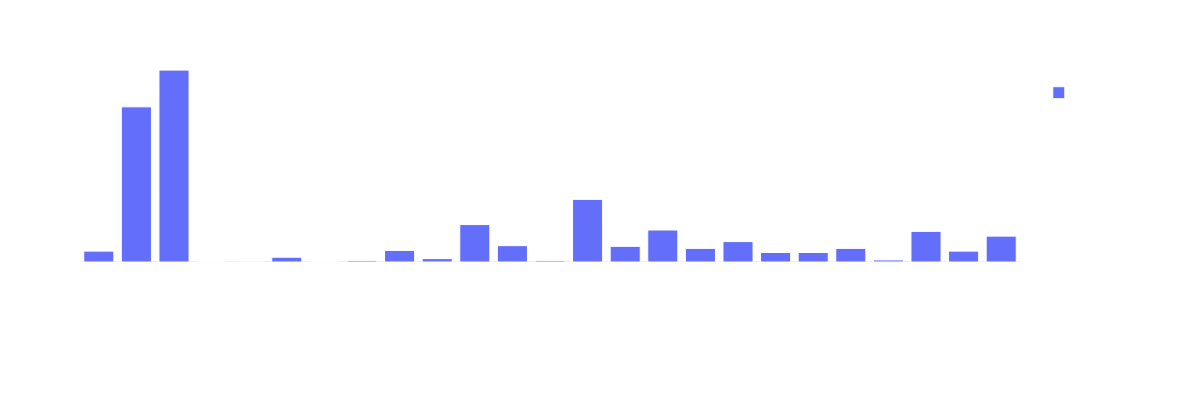

In [48]:
feat_import = list(map(float,np.round(model.feature_importances_,3)))
fig = px.bar(pd.Series(dict(zip(features,feat_import)),
                       name='feature_importance',),template='plotly_white')


# Update layout for transparent background and white fonts
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent outer background[2][3][8]
    plot_bgcolor='rgba(0,0,0,0)',   # Transparent plotting area background[2][3][8]
    title_font=dict(color='white'),  # White plot title
    xaxis_title_font=dict(family="Arial Black, Arial, sans-serif", size=16, color="white"),
    yaxis_title_font=dict(family="Arial Black, Arial, sans-serif", size=16, color="white"),

    legend=dict(
        font=dict(color='white'),  # White legend text
        bgcolor='rgba(0,0,0,0)'   # Transparent legend background
    ),
    title=dict(
        text="Feature Importance of Decision Tree",
        font=dict(
            color='white',
            size=20,
            family='Courier New, monospace'  # Use a bold font family
        )
    )
)


# Update x and y axes for white lines, ticks, labels, and 20% opacity grid
fig.update_xaxes(
    showline=True,         # Show axis line
    linecolor='white',     # White axis line
    tickfont=dict(color='white'),  # White tick labels
    gridcolor='rgba(255,255,255,0.1)',  # White grid lines with 20% opacity
    linewidth=2
)
fig.update_yaxes(
    showline=True,
    linecolor='white',
    tickfont=dict(color='white'),
    gridcolor='rgba(255,255,255,0.1)',  # White grid lines with 20% opacity
    linewidth=2
)

fig.update_traces(
    marker=dict(
        line=dict(color="white", width=1)  # black outline with width 2
    )
)

fig.show('png',width=1200,height=400)

**Important Features**

Now that we have an accurate model, which features are important to predicting **customer churn**

- Age, login frequency, marital status features are amongst the highest contributors to the model predictions

#### SMOTE Upsampling

A common approach to upsampling is called **SMOTE**; which generates similar data observed in the positive class artificially, allowing a more evenly balances label ratio to be generated 

- So lets return to the dataset in which we have a single label for each **CustomerID**, `customID4`

- Instead we'll be artificially upsampling the positve class a little, from 204 labels to 597

- Such an approach has increased the **roc_auc** metrics to **0.72**, which seems like a big indicator that our models lack data for extracting insights

In [49]:
from collections import Counter
from imblearn.over_sampling import SMOTE


# Assume X, y are your features and labels
print("Original class distribution:", Counter(y))

y = customID4['ChurnStatus']
X = customID4.drop(['ChurnStatus'],axis=1)

Original class distribution: Counter({0: 796, 1: 204})


In [50]:
smote = SMOTE(sampling_strategy=0.75, random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

In [51]:
from collections import Counter

# Assume X, y are your features and labels
print("Original class distribution:", Counter(y_resampled))

Original class distribution: Counter({0: 796, 1: 597})


In [52]:
X_resampled = pd.get_dummies(X_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_resampled,
                                                    y_resampled,
                                                    test_size=0.2,
                                                    stratify=y_resampled,random_state=32)

model = DecisionTreeClassifier(
                                max_depth=None,
                                # min_samples_split=2,
                                # min_samples_leaf=5,
                                # criterion='entropy',
                                class_weight='balanced',
                            #    class_weight={1:0.9,0:0.1}
                                random_state=32
                                )
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))
print('roc_auc',round(roc_auc_score(y_test,y_pred),2))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74       159
           1       0.65      0.72      0.69       120

    accuracy                           0.72       279
   macro avg       0.71      0.72      0.71       279
weighted avg       0.72      0.72      0.72       279

roc_auc 0.72


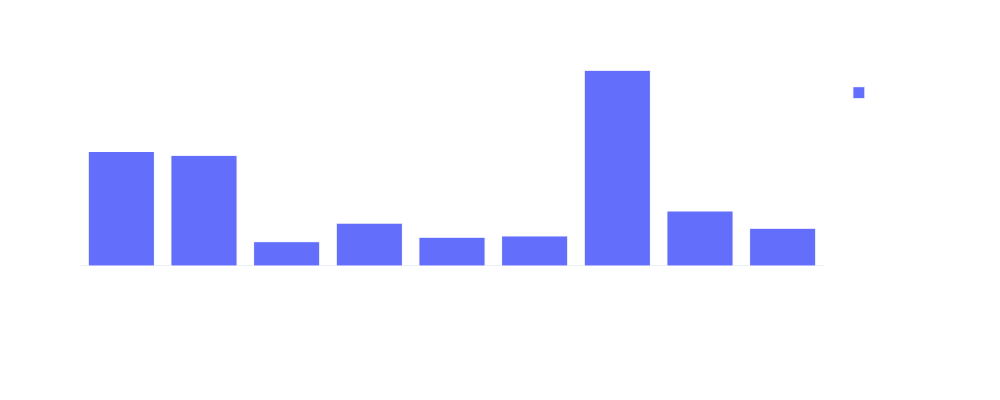

In [53]:
feat_import = list(map(float,np.round(model.feature_importances_,3)))
fig = px.bar(pd.Series(dict(zip(features,feat_import)),
                       name='feature_importance',),template='plotly_white')


# Update layout for transparent background and white fonts
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent outer background[2][3][8]
    plot_bgcolor='rgba(0,0,0,0)',   # Transparent plotting area background[2][3][8]
    title_font=dict(color='white'),  # White plot title
    xaxis_title_font=dict(family="Arial Black, Arial, sans-serif", size=16, color="white"),
    yaxis_title_font=dict(family="Arial Black, Arial, sans-serif", size=16, color="white"),

    legend=dict(
        font=dict(color='white'),  # White legend text
        bgcolor='rgba(0,0,0,0)'   # Transparent legend background
    ),
    title=dict(
        text="Feature Importance of Decision Tree",
        font=dict(
            color='white',
            size=20,
            family='Courier New, monospace'  # Use a bold font family
        )
    )
)


# Update x and y axes for white lines, ticks, labels, and 20% opacity grid
fig.update_xaxes(
    showline=True,         # Show axis line
    linecolor='white',     # White axis line
    tickfont=dict(color='white'),  # White tick labels
    gridcolor='rgba(255,255,255,0.1)',  # White grid lines with 20% opacity
    linewidth=2
)
fig.update_yaxes(
    showline=True,
    linecolor='white',
    tickfont=dict(color='white'),
    gridcolor='rgba(255,255,255,0.1)',  # White grid lines with 20% opacity
    linewidth=2
)

fig.update_traces(
    marker=dict(
        line=dict(color="white", width=1)  # black outline with width 2
    )
)

fig.show('png',width=1000,height=400)

Taking the upsampling approach:

- We can see that the model tends to rely on a **slightly different features** to make preditions to the one above

    - Amount spent for all transactions, age, and furnature category purchase

    - Surprising that **grocery product count** feature was not amongst the highest contributed features since the EDA clearly showed that there is a big difference in purchases made by both groups for this specific subset


<div style="background-color: #25323b; padding: 20px; border-radius: 10px; border-left: 5px solid #3498db; margin-bottom: 20px;">

<h3 style="color: #e1f0fa; margin-top: 0;">📊 Feature Engineering | Summary</h3>

<p><b>Lets review what we learned from this segment</b></p>

<p>The amount of data provided for customers is very limited, creating a challenging problem</p>

<ul>
<li>The binary classification problem was found to have a high imblance of class samples</li>
<li>Specific features were shown the have positive impact, improving the model, however these features were not sufficient enough to create a good working model which generalises well on new data on the customer aggreated data</li>
    <li>Both <b>SMOTE</b> and merging of transactional data together with all other available data created an artificial increase in data (mostly for the positive class), which allowed the model to show better <b>roc_auc</b> results</li> 
    <li><b>Age</b> and specific <b>purchase categories behaviour</b> also are important features in classifying churn</li>
<li><b>Amount spend on transactions</b> play an important role in a models ability to classify churn</li>
<li><b>Marital status</b> for this set of customers was shown the have some impact on churn clasification</li>
</ul>
    
<p>Some key takaways are that we have successfully created models that allow us to predict customers which are prone to churn. This allows us to automate the process of targeting specific customers before they actually do decide to churn. </b></p>

</div>
